In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN 

import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)

<module 'RSI' from 'C:\\Users\\jpran\\Capstone\\RSI.py'>

In [2]:
name = 'CAT' 
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

In [3]:
ori_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

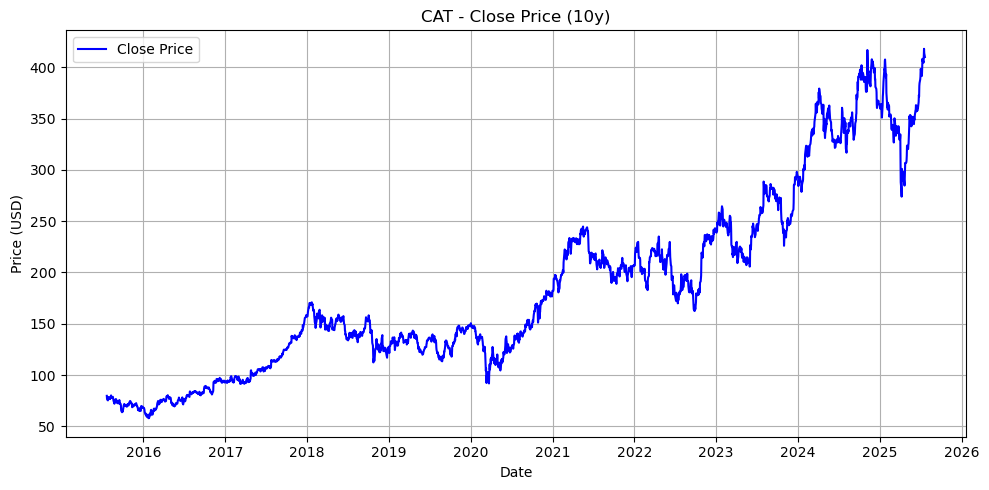

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = ori_df.copy()

In [6]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.09, T=5)

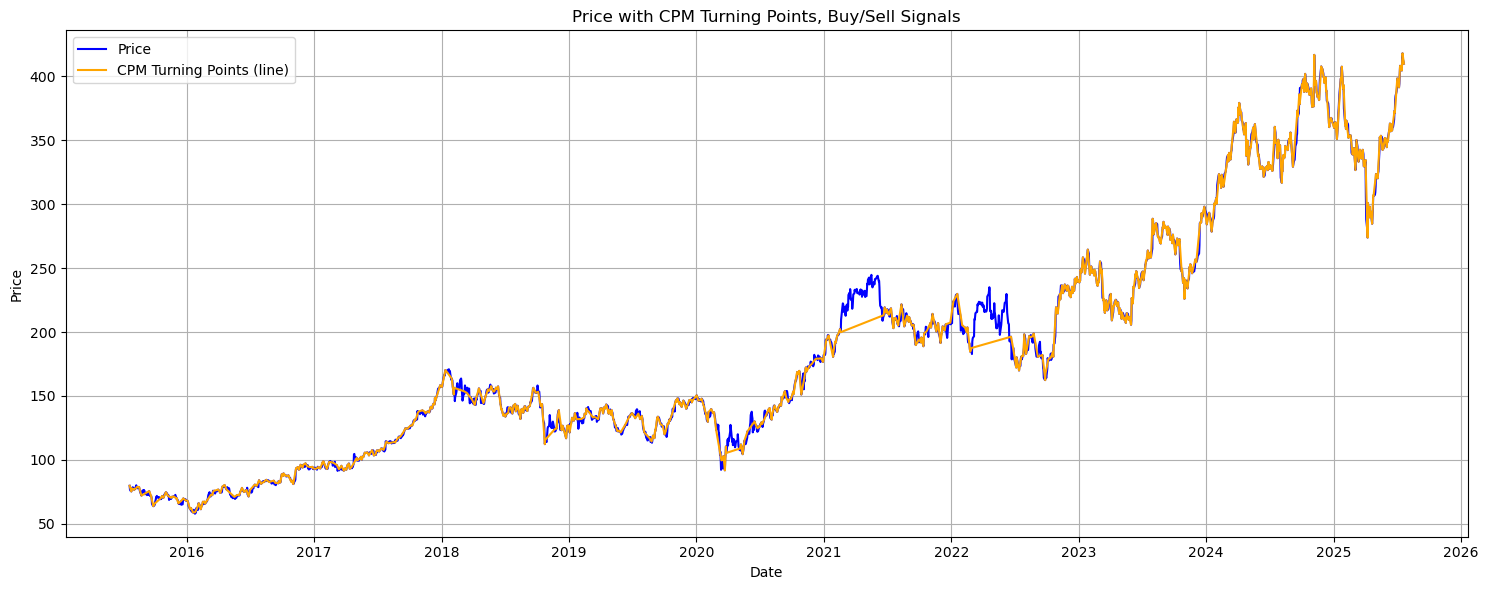

In [7]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [9]:
total_len = len(df)

train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end]
test_df = df_with_cpm.iloc[train_end:]

In [10]:
ma_best_params, ma_best_fitness, train_df = ma.run_MA_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

이동평균 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	1552.72	1522.03	1587.61
1  	39    	inf    	1521.63	inf    
2  	35    	inf    	1504.02	inf    
3  	37    	1534.11	1498.18	1570.76
4  	42    	1522.29	1496.35	1584.33
5  	41    	1515.49	1496.66	1561.81
6  	37    	1510.78	1487.28	1561.69
7  	36    	1508.6 	1480.32	1556.72
8  	34    	1499.98	1471.39	1518.61
9  	43    	1496.93	1469.16	1522.74
10 	34    	1496.25	1471.39	1538.75
11 	46    	1491.08	1463.81	1514.88
12 	33    	1484.42	1463.81	1509.09
13 	40    	1478.52	1462.57	1516.82
14 	38    	1470.26	1461.2 	1493.26
15 	33    	1467.18	1460.41	1494.54
16 	40    	1467.21	1460.15	1492.26
17 	40    	1466.01	1460.15	1503.64
18 	41    	1466.49	1460.15	1505.24
19 	35    	1462.26	1460.15	1480.57
20 	35    	1462.35	1460.15	1502.64
21 	42    	1461.41	1460.15	1487.85
22 	45    	1462.16	1460.15	1496.9 
23 	43    	1461.05	1460.07	1505.18
24 	28    	1460.15	1460.07	1460.15
25 	36    	1461.23	1460.15	1480.58
26 	44    	1460.57	1460.15	1480.58

In [11]:
N, n, a, b, c = ma_best_params

In [12]:
test_ma_signals = ma.generate_MA_signals(test_df, N, n, a, b, c)

In [13]:
signal_map = test_ma_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_19208\4009268628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [14]:
rsi_best_params, rsi_best_fitness, train_df = rsi.run_RSI_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

RSI 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	1540.18	1516.17	1542.25
1  	38    	inf    	1516.17	inf    
2  	37    	inf    	1499.87	inf    
3  	41    	inf    	1493.21	inf    
4  	41    	inf    	1484.44	inf    
5  	34    	inf    	1484.44	inf    
6  	34    	inf    	1484.44	inf    
7  	41    	inf    	1484.44	inf    
8  	35    	inf    	1484.44	inf    
9  	43    	inf    	1484.44	inf    
10 	40    	inf    	1484.44	inf    
11 	39    	inf    	1484.44	inf    
12 	36    	inf    	1484.44	inf    
13 	37    	1493.06	1482.44	1525.31
14 	40    	1495.24	1482.44	1548.41
15 	39    	1492.98	1481.08	1526.96
16 	41    	1488.02	1479.4 	1526.27
17 	37    	1487.93	1479.4 	1523.56
18 	37    	1487.18	1479.4 	1544.44
19 	38    	1484.14	1479.4 	1523.56
20 	39    	1481.72	1479.4 	1487.05
21 	33    	1481.11	1479.4 	1512.4 
22 	41    	1482.82	1479.4 	1523.56
23 	34    	1480.71	1479.4 	1487.05
24 	39    	1483.14	1479.4 	1523.56
25 	32    	1482.26	1479.4 	1523.56
26 	40    	1483.12	1479.4 	1512.4 


In [15]:
x, overbought_level, oversold_level, p, q = rsi_best_params

In [16]:
test_rsi_signals = rsi.generate_RSI_signals(test_df, x, overbought_level, oversold_level, p, q)

503 6.469737624463543


In [17]:
signal_map = test_rsi_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_19208\1229919477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [18]:
Technical_Signals = ['MA_Signals', 'RSI_Signals']

In [19]:
import ESN_GA
from ESN_GA import run_genetic_algorithm, perform_final_backtest, PARAM_RANGES
importlib.reload(ESN_GA)

C:\Users\jpran\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<module 'ESN_GA' from 'C:\\Users\\jpran\\Capstone\\ESN_GA.py'>

In [20]:
best_params_ga, ga_log = run_genetic_algorithm(
    train_df_ga=train_df,
    test_df_ga=test_df,
    technical_signals_list=Technical_Signals,
    pop_size=30,
    num_generations=15,
    random_seed=42
)

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

gen	nevals	avg   	std    	min     	max    
0  	30    	2.5031	29.9917	-55.5766	55.2792


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

1  	25    	4.96715	29.2855	-59.0676	55.2792


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

2  	23    	7.74375	20.8409	-22.9127	55.2792


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

3  	28    	10.3372	24.1427	-54.622 	52.248 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

4  	27    	8.6453 	22.6198	-40.1268	51.5674


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

5  	19    	17.6498	21.9278	-34.8929	51.5674


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

6  	21    	16.0889	21.9955	-27.4638	58.8929


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

7  	30    	12.7151	21.0324	-31.4811	53.0027


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

8  	21    	17.346 	22.5552	-52.0137	53.0027


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

9  	27    	15.6419	26.1073	-34.7723	53.0027


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

10 	25    	8.80711	28.7881	-47.5754	53.0027


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

11 	20    	21.2625	26.4436	-35.4065	54.018 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

12 	23    	23.6087	23.3997	-18.0129	54.018 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

13 	22    	32.7635	21.2063	-24.0452	54.018 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

14 	25    	36.1548	22.2419	-9.53519	54.018 


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

15 	22    	41.9821	17.9059	1.2256  	54.018 

GA 최적화 완료 - 최적 하이퍼파라미터: [767.9560648414167, 0.8792540843918735, 0.36911168102769143, 0.4968668642261677]
GA 최적화 완료 - 최고 Return [%]: 58.8929


In [21]:
print(best_params_ga)

[767.9560648414167, 0.8792540843918735, 0.36911168102769143, 0.4968668642261677]


In [22]:
final_backtest_stats, final_signals = perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_ga,
    technical_signals_list=Technical_Signals,
    random_state=42
)


--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 768
  spectral_radius: 0.8793
  sparsity: 0.3691
  signal_threshold: 0.4969


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-07-19 00:00:00
End                       2025-07-21 00:00:00
Duration                    733 days 00:00:00
Exposure Time [%]                    97.01789
Equity Final [$]                  15889.28701
Equity Peak [$]                   16572.10001
Commissions [$]                     308.36768
Return [%]                           58.89287
Buy & Hold Return [%]                56.06851
Return (Ann.) [%]                    26.11075
Volatility (Ann.) [%]                35.58156
CAGR [%]                             17.25685
Sharpe Ratio                          0.73383
Sortino Ratio                         1.41971
Calmar Ratio                          0.77621
Alpha [%]                              4.9431
Beta                                  0.96221
Max. Drawdown [%]                   -33.63883
Avg. Drawdown [%]                    -5.58793
Max. Drawdown Duration      257 days 00:00:00
Avg. Drawdown Duration       37 days 00:00:00
# Trades 

In [23]:
def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
    plt.figure(figsize=(16, 8))
    plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

    # ESN 예측 매수 신호 (BUY) 표시
    buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'],
                marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

    # ESN 예측 매도 신호 (SELL) 표시
    sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'],
                marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

    # --- CPM Point Type ---
    if 'cpm_point_type' in original_df.columns:
        cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
        cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

        # CPM BUY 포인트
        plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                    marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

        # CPM SELL 포인트
        plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                    marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
    else:
        print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

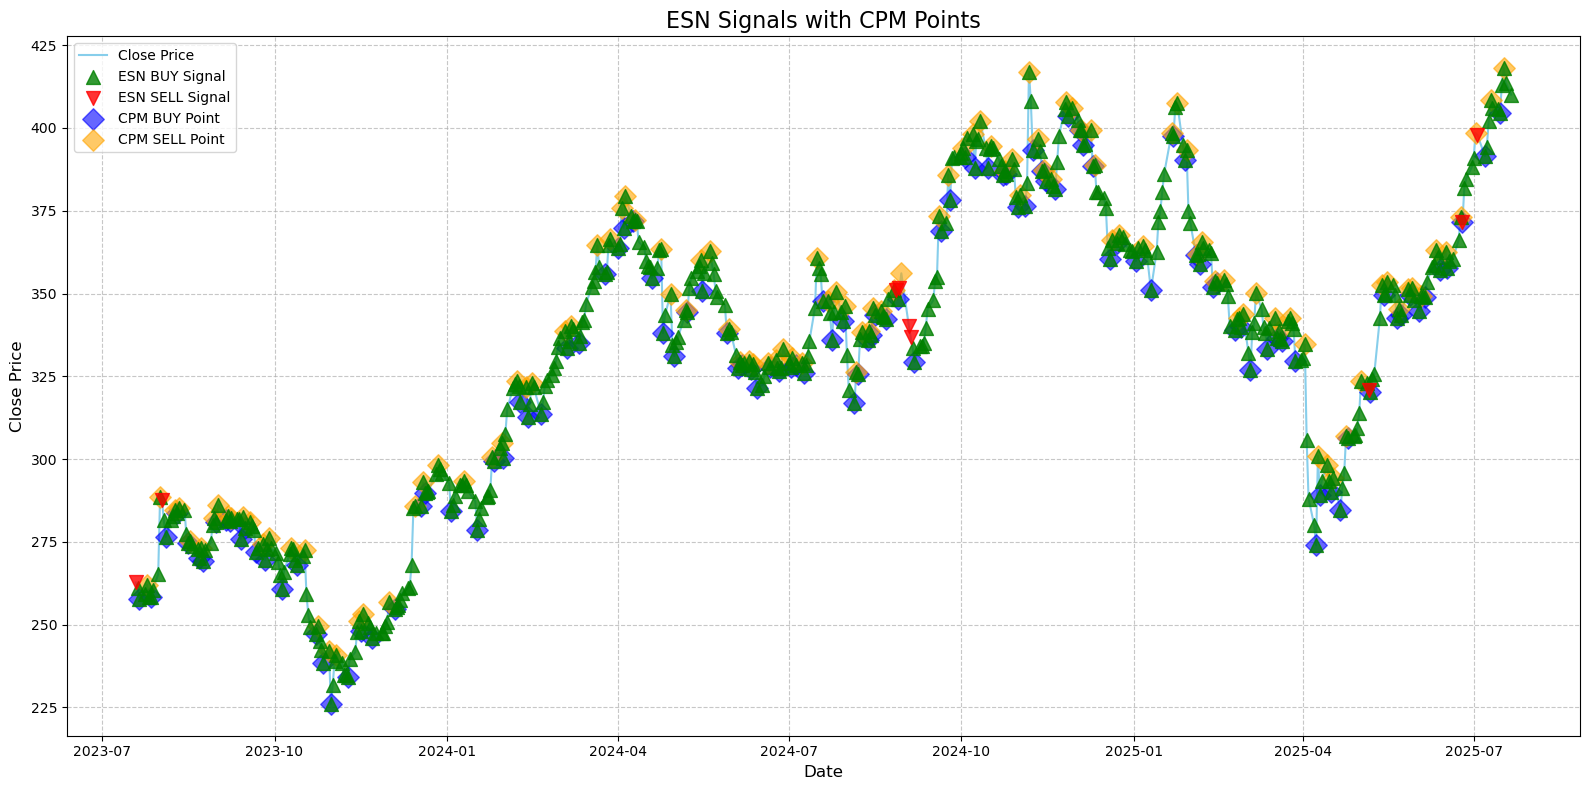

In [24]:
plot_signals(test_df, final_signals)